# Fraud Detection - Model Training

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import joblib
import mlflow
import mlflow.sklearn
import mlflow.xgboost
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, average_precision_score, roc_auc_score

import warnings
warnings.filterwarnings('ignore')

# Configure MLflow to use Docker MLflow server
mlflow.set_tracking_uri("http://localhost:5500")
mlflow.set_experiment("Real-Time Fraud Detection")
print(f"MLflow Tracking URI: {mlflow.get_tracking_uri()}")

MLflow Tracking URI: http://localhost:5500


## Load Feature-Engineered Data

In [3]:
df = pd.read_csv("../DATA/feature_engineering.csv")
print(f"Data shape: {df.shape}")
df.head()

Data shape: (4999997, 38)


,sender_account,receiver_account,amount,transaction_type,merchant_category,location,device_used,is_fraud,time_since_last_transaction,spending_deviation_score,...,receiver_degree,sender_total_transaction,receiver_total_transaction,sender_avg_amount,sender_std_amount,sender_fraud_transaction,receiver_fraud_transaction,sender_fraud_percentage,receiver_fraud_percentage,deviation_squared
0,158871,89037,12.25,2,1,1,0,0,-7559.966086,-0.32,...,5,7,5,257.182857,252.287044,0,0,0.0,0.0,0.1024
1,376957,4992,1347.27,0,6,5,1,0,1.525799,-0.68,...,5,11,5,369.233636,473.217498,0,1,0.0,20.0,0.4624
2,727819,491398,20.79,1,6,6,3,0,-4568.663237,0.14,...,8,5,8,170.508000,189.434766,0,1,0.0,12.5,0.0196
3,545869,270273,740.73,0,7,0,1,0,1.525799,-2.09,...,4,6,4,371.636667,411.455138,0,0,0.0,0.0,4.3681
4,880977,66830,228.67,0,1,1,1,0,-48.738700,0.16,...,8,6,8,666.570000,581.488102,0,0,0.0,0.0,0.0256


In [9]:
df.isna().sum()

sender_account                 0
receiver_account               0
amount                         0
transaction_type               0
merchant_category              0
location                       0
device_used                    0
is_fraud                       0
time_since_last_transaction    0
spending_deviation_score       0
velocity_score                 0
geo_anomaly_score              0
payment_channel                0
ip_address                     0
device_hash                    0
hour                           0
day                            0
day_of_week                    0
month                          0
amount_per_velocity            0
amount_log                     0
amount_to_avg_ratio            0
transaction_per_day            0
transaction_gap                0
is_night_transaction           0
is_weekend                     0
is_self_transfer               0
sender_degree                  0
receiver_degree                0
sender_total_transaction       0
receiver_t

## Data Balancing

In [4]:
# Separate majority and minority classes
df_majority = df[df['is_fraud'] == 0]
df_minority = df[df['is_fraud'] == 1]

print(f"Original distribution:")
print(f"  Legitimate (0): {len(df_majority)}")
print(f"  Fraud (1): {len(df_minority)}")

# Downsample majority class
df_majority_downsampled = df_majority.sample(n=2*len(df_minority), random_state=36)
df_balanced = pd.concat([df_majority_downsampled, df_minority])

print(f"\nBalanced distribution:")
print(f"  Total samples: {len(df_balanced)}")
print(df_balanced['is_fraud'].value_counts())

Original distribution:
  Legitimate (0): 4820444
  Fraud (1): 179553

Balanced distribution:
  Total samples: 538659
is_fraud
0    359106
1    179553
Name: count, dtype: int64


## Train-Test Split

In [5]:
# Prepare features and target
y = df_balanced['is_fraud']
X = df_balanced.drop(columns=['is_fraud'])

# Split into train, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=36, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=1/8, random_state=36, stratify=y_train)

print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Test set: {X_test.shape}")

Training set: (377061, 37)
Validation set: (53866, 37)
Test set: (107732, 37)


In [6]:
X_train.head()

,sender_account,receiver_account,amount,transaction_type,merchant_category,location,device_used,time_since_last_transaction,spending_deviation_score,velocity_score,...,receiver_degree,sender_total_transaction,receiver_total_transaction,sender_avg_amount,sender_std_amount,sender_fraud_transaction,receiver_fraud_transaction,sender_fraud_percentage,receiver_fraud_percentage,deviation_squared
1797907,454421,595555,10.59,1,7,7,3,-513.147782,1.07,1.0,...,7,3,7,298.150000,490.691252,0,0,0.00,0.00,1.1449
4194814,582320,381416,0.01,3,4,4,1,-968.251159,0.98,1.0,...,6,6,6,391.736667,384.233680,1,1,16.67,16.67,0.9604
1794557,867476,432200,400.17,3,5,6,3,-783.914933,0.50,7.0,...,4,12,4,90.195000,113.698611,2,1,16.67,25.00,0.2500
3131045,738551,538666,28.62,2,5,1,0,4526.227507,-0.83,2.0,...,10,12,10,642.475000,698.102656,1,0,8.33,0.00,0.6889
4624944,823135,367741,166.50,3,1,6,0,6386.181629,1.21,15.0,...,8,6,8,181.150000,268.272756,0,0,0.00,0.00,1.4641


Training XGBoost model with MLflow tracking...
[18:15:42] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\iterative_dmatrix.cc:56: Finished constructing the `IterativeDMatrix`: (377061, 37, 13951257).
[18:15:42] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\iterative_dmatrix.cc:56: Finished constructing the `IterativeDMatrix`: (53866, 37, 1993042).
[18:15:42] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\ellpack_page.cu:167: Ellpack is dense.
[18:15:43] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\ellpack_page.cu:167: Ellpack is dense.
[0]	validation_0-aucpr:0.96218	validation_1-aucpr:0.96161
[50]	validation_0-aucpr:0.97939	validation_1-aucpr:0.97429
[100]	validation_0-aucpr:0.98732	validation_1-aucpr:0.97351
[150]	validation_0-aucpr:0.99288	validation_1-aucpr:0.97325
[200]	validation_0-aucpr:0.99681	validation_1-aucpr:0.97313
[250]	validation_0-aucpr:0.99906	validation_1-aucpr:0.97270
[299]	validation_0-aucpr:0.99975	validation_1-aucpr:0.97236
XGBoos

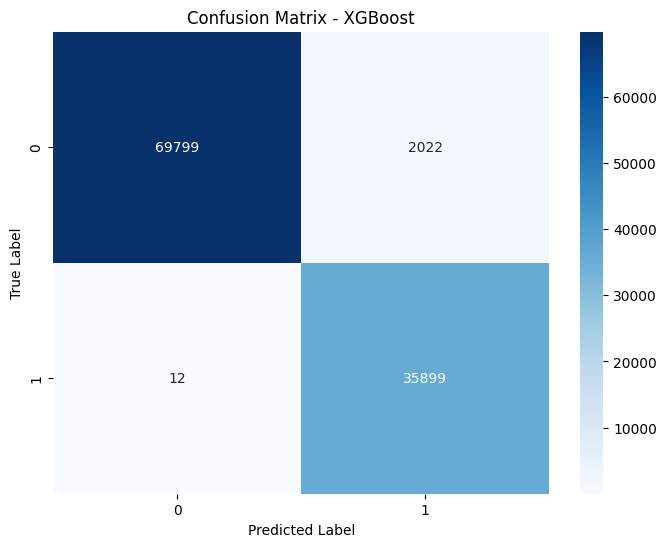


MLflow Run ID: 7673cbe747a144a3908e9f258a8d1276
✓ Model saved locally to: ../models/best_fraud_detection_model.pkl
✓ Metrics and parameters logged to MLflow (localhost:5500)
🏃 View run XGBoost_Fraud_Detection at: http://localhost:5500/#/experiments/1/runs/7673cbe747a144a3908e9f258a8d1276
🧪 View experiment at: http://localhost:5500/#/experiments/1


In [8]:
from xgboost import XGBClassifier

# Start MLflow run to track this experiment
with mlflow.start_run(run_name="XGBoost_Fraud_Detection"):
    
    # Calculate scale_pos_weight for handling class imbalance
    scale_pos_weight = y_train[y_train == 1].count() / y_train[y_train == 0].count()
    
    # Define model hyperparameters
    params = {
        'n_estimators': 300,
        'objective': 'binary:logistic',
        'tree_method': 'hist',
        'max_depth': 12,
        'learning_rate': 0.05,
        'reg_lambda': 3.6,
        'reg_alpha': 3.6,
        'scale_pos_weight': scale_pos_weight,
        'eval_metric': 'aucpr',
        'verbosity': 2,
        'subsample': 0.8,
        'device': 'cuda',
        'n_jobs': -1,
        'random_state': 36
    }
    
    # Create and train XGBoost model
    xgb_model = XGBClassifier(**params)
    
    print("Training XGBoost model with MLflow tracking...")
    eval_set = [(X_train, y_train), (X_val, y_val)]
    xgb_model.fit(X_train, y_train, eval_set=eval_set, verbose=50)
    print("XGBoost training completed!")
    
    # Make predictions
    y_pred_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]
    y_pred_xgb = xgb_model.predict(X_test)
    
    # Calculate metrics
    from sklearn.metrics import precision_score, recall_score, f1_score
    
    precision = float(precision_score(y_test, y_pred_xgb))
    recall = float(recall_score(y_test, y_pred_xgb))
    f1 = float(f1_score(y_test, y_pred_xgb))
    auc_pr = float(average_precision_score(y_test, y_pred_proba_xgb))
    auc_roc = float(roc_auc_score(y_test, y_pred_proba_xgb))
    
    # Log hyperparameters + metrics to MLflow
    mlflow.log_params(params)
    mlflow.log_params({
        "train_samples": len(X_train),
        "test_samples": len(X_test),
        "val_samples": len(X_val),
        "n_features": X_train.shape[1],
        "fraud_rate_train": float(y_train.mean())
    })
    mlflow.log_metrics({
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "auc_pr": auc_pr,
        "auc_roc": auc_roc
    })
    
    print(f"\n{'='*60}")
    print("Model Metrics:")
    print(f"{'='*60}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1 Score:  {f1:.4f}")
    print(f"AUC-PR:    {auc_pr:.4f}")
    print(f"AUC-ROC:   {auc_roc:.4f}")
    print(f"{'='*60}\n")
    
    # Log confusion matrix as artifact
    cm = confusion_matrix(y_test, y_pred_xgb)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix - XGBoost')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    # Save model local
    os.makedirs("../models", exist_ok=True)
    joblib.dump(xgb_model, "../models/best_fraud_detection_model.pkl")
    
    # Get MLflow run info
    run_id = mlflow.active_run().info.run_id
    print(f"\nMLflow Run ID: {run_id}")
    print(f"✓ Model saved locally to: ../models/best_fraud_detection_model.pkl")
    print(f"✓ Metrics and parameters logged to MLflow (localhost:5500)")